In [63]:
%pylab inline

from __future__ import print_function
import numpy as np
import theano
import theano.tensor as T
import time
import datetime
import os

import lasagne
from copy import deepcopy

import SimpleITK as sitk
import random
from skimage import exposure
from skimage.morphology import binary_closing

import sklearn.cross_validation

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [24]:
def extract_patches(mri, label, half_patch_size=5):
    
    assert mri.shape == label.shape
    
    z_size, x_size, y_size = mri.shape
    positive_patches = []
    negative_patches = []

    for z in xrange(half_patch_size, z_size-half_patch_size):
        for x in xrange(half_patch_size, x_size-half_patch_size):
            for y in xrange(half_patch_size, y_size-half_patch_size):
                if label[z,x,y] == 1:
                    positive_patches.append(mri[z-half_patch_size:z+half_patch_size,x-half_patch_size:x+half_patch_size,y-half_patch_size:y+half_patch_size])
                elif label[z,x,y] == 0:
                    negative_patches.append(mri[z-half_patch_size:z+half_patch_size,x-half_patch_size:x+half_patch_size,y-half_patch_size:y+half_patch_size])
    
    random.shuffle(negative_patches)
    selected_negative_patches = deepcopy(negative_patches[:len(positive_patches)])
    del(negative_patches)
    
    return (positive_patches, selected_negative_patches)

In [25]:
def patchimg2differentview(patch):
    
    z_size, x_size, y_size = patch.shape
    
    X = np.zeros((z_size * 3, x_size, y_size), dtype=np.float32)
    
    counter = 0
    for z in xrange(z_size):
        X[counter,:,:] = patch[z,:,:]
        counter += 1
    for x in xrange(x_size):
        X[counter,:,:] = patch[:,x,:]
        counter += 1
    for y in xrange(y_size):
        X[counter,:,:] = patch[:,:,y]
        counter += 1
    
    return X.astype(np.float32)

In [26]:
def patches2CNNformat(patches, label):
    
    X = np.zeros((len(patches), 30, 10, 10), dtype=np.float32)
    y = np.zeros((len(patches)), dtype=np.int32) * -1
    
    for i, patch in enumerate(patches):
        X[i,:,:,:] = patchimg2differentview(patch)
        y[i] = label
    
    assert -1 not in y
    
    return X.astype(np.float32), y.astype(np.int32)

In [27]:
def get_resized_img(img_fn, data_type = sitk.sitkFloat32):
    
    img = sitk.ReadImage(img_fn)
    size = img.GetSize()
    ratio = [1.0/i for i in img.GetSpacing()]
    new_size = [int(size[i]/ratio[i]) for i in range(3)]
    
    rimage = sitk.Image(new_size, data_type)
    rimage.SetSpacing((1,1,1))
    rimage.SetOrigin(img.GetOrigin())
    tx = sitk.Transform()
    
    interp = sitk.sitkLinear
    if data_type == sitk.sitkInt16:
        interp = sitk.sitkNearestNeighbor
    
    new_image = sitk.Resample(img, rimage, tx, interp, data_type)
    
    return sitk.GetArrayFromImage(new_image)

In [28]:
def needles2tips(only_needles, image_array):
    needles_masks_array = np.zeros_like(image_array).astype(float)  
    for file_item in only_needles:
        this_mask = file_item.astype(np.float)
        if np.sum(this_mask) < (np.shape(this_mask)[0] * np.shape(this_mask)[1] * np.shape(this_mask)[2]):
            this_mask = binary_closing(this_mask,selem=np.ones((3,3,3)))
            found=False
            row = 0#np.shape(this_mask)[0]-1
            while found==False and row < np.shape(this_mask)[0]-1 :
                #print(row)
                this_row = this_mask[row,:,:]
                if np.sum(this_row) > 0:
                    #print(row)
                    found = True
                    temp = np.add(needles_masks_array[row:row+3,:,:],this_mask[row:row+3,:,:]) 
                    needles_masks_array[row:row+3,:,:] = temp 
                row += 1
    return needles_masks_array.astype(np.int32)

In [52]:
def data_for_CNN(general_folder):
    folders_cases = os.listdir(general_folder)
    
    X_pos = np.ones((1, 30, 10, 10), dtype=np.float32) * -1.0
    y_pos = np.ones((1), dtype=np.int32) * -1.0
    
    X_neg = np.ones((1, 30, 10, 10), dtype=np.float32) * -1.0
    y_neg = np.ones((1), dtype=np.int32) * -1.0
    
    for folder_case in folders_cases:
        full_case_path = general_folder + os.sep + folder_case
        
        volumetric_files = os.listdir(full_case_path)
        
        assert "case.nrrd" in volumetric_files
        del(volumetric_files[volumetric_files.index("case.nrrd")])
        
        mri = get_resized_img(full_case_path + os.sep + "case.nrrd")[::-1,:,:]
        
        needles = []
        for volumetric_file in volumetric_files:
            #print(volumetric_file)
            label = get_resized_img(full_case_path + os.sep + volumetric_file, sitk.sitkInt16)[::-1,:,:]
            label[label!=0]=1
            needles.append(label)
        
        tips = needles2tips(needles, mri)
        tips[tips!=0]=1
        tips = tips.astype(np.int32)
        print(tips.max())
        positive_patches, negative_patches = extract_patches(mri, tips, half_patch_size=5)
        print(len(positive_patches), len(negative_patches))
        X_temp_pos, y_temp_pos = patches2CNNformat(positive_patches, 1)
        X_temp_neg, y_temp_neg = patches2CNNformat(negative_patches, 0)
        print(X_temp_neg.shape)
            
        X_pos = np.concatenate((X_pos, X_temp_pos), axis=0)
        y_pos = np.concatenate((y_pos, y_temp_pos), axis=0)
        X_neg = np.concatenate((X_neg, X_temp_neg), axis=0)
        y_neg = np.concatenate((y_neg, y_temp_neg), axis=0)
    
    assert -1 in X_neg[0,:,:,:] and y_neg[0] == -1
    X_neg = X_neg[1:,:,:,:].astype(np.float32)
    y_neg = y_neg[1:].astype(np.int32)
    
    assert -1 in X_pos[0,:,:,:] and y_pos[0] == -1
    X_pos = X_pos[1:,:,:,:].astype(np.float32)
    y_pos = y_pos[1:].astype(np.int32)
    
    return X_pos, y_pos, X_neg, y_neg, tips, mri

In [53]:
X_pos, y_pos, X_neg, y_neg, tips, mri = data_for_CNN("CNN_testing_data/testing_cases")

1
0 0
(0, 30, 10, 10)
1
93 93
(93, 30, 10, 10)


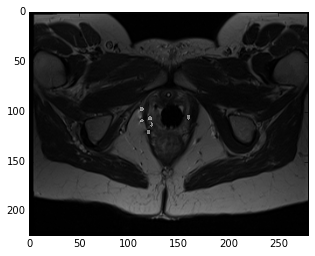

In [47]:
imshow(mri[1,:,:], cmap="gray")
imshow(tips[1,:,:], cmap="gray", interpolation="nearest", alpha=0.5)

1


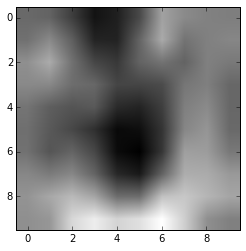

In [62]:
ind_p = 60
imshow(X_pos[ind_p,5,:,:], cmap="gray") #, interpolation="nearest")
print(y_pos[ind_p])

0


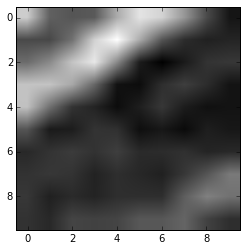

In [61]:
ind_n = 60
imshow(X_neg[ind_n,5,:,:], cmap="gray") #, interpolation="nearest")
print(y_neg[ind_n])

In [69]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X_pos, y_pos, test_size=0.20)
X_test, X_val, y_test, y_val = sklearn.cross_validation.train_test_split(X_test, y_test, test_size=0.33)

In [70]:
X_train.shape, X_test.shape, X_val.shape

((74, 30, 10, 10), (12, 30, 10, 10), (7, 30, 10, 10))